In [1]:
!pip install pyspark==3.5.0 delta-spark==3.1.0

from pyspark.sql import SparkSession
from delta import configure_spark_with_delta_pip
from pyspark.sql import functions as F, types as T
import datetime


# 1. Spark Session with Delta Support

In [30]:

builder = (
    SparkSession.builder.appName("DeltaRideHailing")
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
)
spark = configure_spark_with_delta_pip(builder).getOrCreate()

print(" Spark Session Created with Delta Support")

 Spark Session Created with Delta Support


# 2. Schema Definitions

In [31]:
trip_schema = T.StructType([
    T.StructField("trip_id", T.IntegerType()),
    T.StructField("rider_id", T.StringType()),
    T.StructField("driver_id", T.StringType()),
    T.StructField("city", T.StringType()),
    T.StructField("distance_km", T.DoubleType()),
    T.StructField("fare", T.DoubleType()),
    T.StructField("tip", T.DoubleType()),
    T.StructField("ts", T.TimestampType())
])

driver_schema = T.StructType([
    T.StructField("driver_id", T.StringType()),
    T.StructField("driver_name", T.StringType()),
    T.StructField("rating", T.DoubleType()),
    T.StructField("vehicle", T.StringType())
])

# Inline Data

In [32]:

trips_rows = [
    (1001, "R001", "D010", "Bengaluru", 12.4, 320.0, 20.0, datetime.datetime(2025,8,8,8,5,0)),
    (1002, "R002", "D011", "Hyderabad", 6.2, 150.0, 10.0, datetime.datetime(2025,8,8,8,15,0)),
    (1003, "R003", "D012", "Pune", 3.5, 90.0, 0.0, datetime.datetime(2025,8,8,8,20,0)),
    (1004, "R001", "D010", "Bengaluru", 18.9, 480.0, 25.0, datetime.datetime(2025,8,8,8,45,0)),
    (1005, "R004", "D013", "Chennai", 10.0, 260.0, 15.0, datetime.datetime(2025,8,8,9,5,0)),
    (1006, "R005", "D012", "Pune", 2.2, 70.0, 0.0, datetime.datetime(2025,8,8,9,10,0))
]

drivers_rows = [
    ("D010", "Anil", 4.8, "WagonR"),
    ("D011", "Sana", 4.6, "i20"),
    ("D012", "Rakesh", 4.4, "Swift"),
    ("D013", "Meera", 4.9, "Ciaz")
]

In [33]:
trips_df = spark.createDataFrame(trips_rows, schema=trip_schema)
drivers_df = spark.createDataFrame(drivers_rows, schema=driver_schema)

In [34]:
BASE = "/tmp/delta/ride_hailing"
TRIPS_PATH = f"{BASE}/trips"
DRIVERS_PATH = f"{BASE}/drivers"

trips_df.write.format("delta").mode("overwrite").save(TRIPS_PATH)
drivers_df.write.format("delta").mode("overwrite").save(DRIVERS_PATH)

print(" Seeded Data:")
print("   Trips  ->", TRIPS_PATH)
print("   Drivers->", DRIVERS_PATH)

 Seeded Data:
   Trips  -> /tmp/delta/ride_hailing/trips
   Drivers-> /tmp/delta/ride_hailing/drivers


In [35]:
print("\nTrips DataFrame:")
trips_df.show()
print("\nDrivers DataFrame:")
drivers_df.show()


Trips DataFrame:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+


Drivers DataFrame:
+---------+-----------+------+-------+
|driver_id|driver_name|rating|vehicle|
+---------+-----------+------+-------+
|     D010|       Anil| 

#Managed and Unmanaged Tables

In [37]:
print("\n===  Managed vs Unmanaged Tables ===")
spark.sql("DROP TABLE IF EXISTS trips_managed")
spark.sql("DROP TABLE IF EXISTS drivers_ext")

spark.sql(f"CREATE TABLE trips_managed USING DELTA LOCATION '{TRIPS_PATH}'")
spark.sql(f"CREATE TABLE drivers_ext USING DELTA LOCATION '{DRIVERS_PATH}'")

print("\nTrips Managed Table Detail:")
spark.sql("DESCRIBE DETAIL trips_managed").show(truncate=False)
print("\nDrivers External Table Detail:")
spark.sql("DESCRIBE DETAIL drivers_ext").show(truncate=False)

print("\nDifference: Managed tables store data inside warehouse; unmanaged tables keep data at external path.")



===  Managed vs Unmanaged Tables ===

Trips Managed Table Detail:
+------+------------------------------------+-----------------------------------+-----------+----------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|format|id                                  |name                               |description|location                          |createdAt              |lastModified           |partitionColumns|numFiles|sizeInBytes|properties|minReaderVersion|minWriterVersion|tableFeatures           |
+------+------------------------------------+-----------------------------------+-----------+----------------------------------+-----------------------+-----------------------+----------------+--------+-----------+----------+----------------+----------------+------------------------+
|delta |8062238e-e862-450e-a272-3ead1a4223e3|spark_catalog.default.trips_manag

#Read & Explore

In [38]:
print("\n===  Read & Explore ===")
trips = spark.read.format("delta").load(TRIPS_PATH)
drivers = spark.read.format("delta").load(DRIVERS_PATH)

trips.printSchema()
drivers.printSchema()

trips.withColumn("total_amount", F.col("fare") + F.col("tip")) \
     .orderBy(F.desc("total_amount")) \
     .show(5, truncate=False)


===  Read & Explore ===
root
 |-- trip_id: integer (nullable = true)
 |-- rider_id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- distance_km: double (nullable = true)
 |-- fare: double (nullable = true)
 |-- tip: double (nullable = true)
 |-- ts: timestamp (nullable = true)

root
 |-- driver_id: string (nullable = true)
 |-- driver_name: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- vehicle: string (nullable = true)

+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|trip_id|rider_id|driver_id|city     |distance_km|fare |tip |ts                 |total_amount|
+-------+--------+---------+---------+-----------+-----+----+-------------------+------------+
|1004   |R001    |D010     |Bengaluru|18.9       |480.0|25.0|2025-08-08 08:45:00|505.0       |
|1001   |R001    |D010     |Bengaluru|12.4       |320.0|20.0|2025-08-08 08:05:00|340.0       |
|1005   |R004    |D

#Update

In [39]:

print("\n=== Update Tip for Bengaluru Trips (distance > 15) ===")
from delta.tables import DeltaTable
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
print("Before update:")
delta_trips.toDF().filter((F.col("city")=="Bengaluru") & (F.col("distance_km")>15)).show()

delta_trips.update(
    condition="city = 'Bengaluru' AND distance_km > 15",
    set={"tip": "tip + 5"}
)

print("After update:")
delta_trips.toDF().filter((F.col("city")=="Bengaluru") & (F.col("distance_km")>15)).show()


=== Update Tip for Bengaluru Trips (distance > 15) ===
Before update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+

After update:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|30.0|2025-08-08 08:45:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#Delete Bad Data

In [40]:
print("\n===  Delete Bad Data ===")
delta_trips.delete("fare <= 0 OR distance_km <= 0")
print("Remaining rows count:", delta_trips.toDF().count())


===  Delete Bad Data ===
Remaining rows count: 6


# Merge (Upsert)

In [41]:

print("\n=== Merge New Batch ===")
new_data = [
    (1004, "R001", "D010", "Bengaluru", 18.9, 500.0, 30.0, datetime.datetime(2025,8,8,8,45,0)),
    (1007, "R006", "D011", "Hyderabad", 8.0, 180.0, 12.0, datetime.datetime(2025,8,8,9,20,0))
]
new_df = spark.createDataFrame(new_data, schema=trip_schema)

delta_trips.alias("t").merge(
    new_df.alias("n"),
    "t.trip_id = n.trip_id"
).whenMatchedUpdateAll().whenNotMatchedInsertAll().execute()

delta_trips.toDF().filter(F.col("trip_id").isin([1004,1007])).show()


=== Merge New Batch ===
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1007|    R006|     D011|Hyderabad|        8.0|180.0|12.0|2025-08-08 09:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



# Gold View KPIs

In [42]:
print("\n===  Gold View KPIs ===")
gold_df = delta_trips.toDF().join(drivers, "driver_id") \
    .withColumn("total_amount", F.col("fare") + F.col("tip")) \
    .select("trip_id","city","driver_name","rating","distance_km","total_amount","ts")

print("\nCity-wise total revenue and avg driver rating:")
gold_df.groupBy("city").agg(F.sum("total_amount").alias("total_revenue"),
                            F.avg("rating").alias("avg_rating")).show()

print("\nDriver-wise total trips and top 3 by revenue:")
gold_df.groupBy("driver_name").agg(F.count("*").alias("total_trips"),
                                   F.sum("total_amount").alias("total_revenue")) \
      .orderBy(F.desc("total_revenue")).show(3)


===  Gold View KPIs ===

City-wise total revenue and avg driver rating:
+---------+-------------+----------+
|     city|total_revenue|avg_rating|
+---------+-------------+----------+
|  Chennai|        275.0|       4.9|
|     Pune|        160.0|       4.4|
|Bengaluru|        870.0|       4.8|
|Hyderabad|        352.0|       4.6|
+---------+-------------+----------+


Driver-wise total trips and top 3 by revenue:
+-----------+-----------+-------------+
|driver_name|total_trips|total_revenue|
+-----------+-----------+-------------+
|       Anil|          2|        870.0|
|       Sana|          2|        352.0|
|      Meera|          1|        275.0|
+-----------+-----------+-------------+
only showing top 3 rows



# Time Travel & History

In [44]:
print("\n===  Time Travel & History ===")
spark.sql(f"DESCRIBE HISTORY delta.`{TRIPS_PATH}`").show(truncate=False)



===  Time Travel & History ===
+-------+-----------------------+------+--------+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----+--------+---------+-----------+--------------+-------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------

In [45]:

print("\nVersion 0 data:")
spark.read.format("delta").option("versionAsOf",0).load(TRIPS_PATH).show()


Version 0 data:
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|480.0|25.0|2025-08-08 08:45:00|
|   1005|    R004|     D013|  Chennai|       10.0|260.0|15.0|2025-08-08 09:05:00|
|   1006|    R005|     D012|     Pune|        2.2| 70.0| 0.0|2025-08-08 09:10:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
|   1002|    R002|     D011|Hyderabad|        6.2|150.0|10.0|2025-08-08 08:15:00|
|   1003|    R003|     D012|     Pune|        3.5| 90.0| 0.0|2025-08-08 08:20:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#Partitioned Rewrite

In [46]:
print("\n===  Partitioned Rewrite ===")
PART_PATH = f"{BASE}/trips_partitioned"
delta_trips.toDF().write.format("delta").mode("overwrite").partitionBy("city").save(PART_PATH)
spark.read.format("delta").load(PART_PATH).filter("city='Bengaluru'").show()


===  Partitioned Rewrite ===
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|     city|distance_km| fare| tip|                 ts|
+-------+--------+---------+---------+-----------+-----+----+-------------------+
|   1004|    R001|     D010|Bengaluru|       18.9|500.0|30.0|2025-08-08 08:45:00|
|   1001|    R001|     D010|Bengaluru|       12.4|320.0|20.0|2025-08-08 08:05:00|
+-------+--------+---------+---------+-----------+-----+----+-------------------+



#Incremental Load

In [47]:
print("\n=== Incremental Load ===")
incremental_rows = [
    (1008,"R007","D013","Mumbai", 5.0, 200.0, 15.0, datetime.datetime(2025,8,8,10,0,0)),
    (1009,"R008","D012","Mumbai", 7.0, 250.0, 20.0, datetime.datetime(2025,8,8,10,5,0))
]
spark.createDataFrame(incremental_rows, trip_schema).write.format("delta").mode("append").save(TRIPS_PATH)
delta_trips = DeltaTable.forPath(spark, TRIPS_PATH)
delta_trips.toDF().groupBy("city").agg(F.sum(F.col("fare")+F.col("tip")).alias("total_revenue")).show()



=== Incremental Load ===
+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|  Chennai|        275.0|
|     Pune|        160.0|
|Bengaluru|        870.0|
|Hyderabad|        352.0|
|   Mumbai|        485.0|
+---------+-------------+



#Simple Streaming

In [48]:
print("\n=== Simple Streaming ===")
stream_df = spark.readStream.format("delta").load(TRIPS_PATH)
query = stream_df.writeStream.format("console").outputMode("append").trigger(processingTime="5 seconds").start()


import time
time.sleep(5)
new_trip = [(1010,"R009","D011","Mumbai", 6.0, 220.0, 18.0, datetime.datetime(2025,8,8,10,10,0))]
spark.createDataFrame(new_trip, trip_schema).write.format("delta").mode("append").save(TRIPS_PATH)

time.sleep(10)
query.stop()


=== Simple Streaming ===


#Visualization


===  Visualization ===


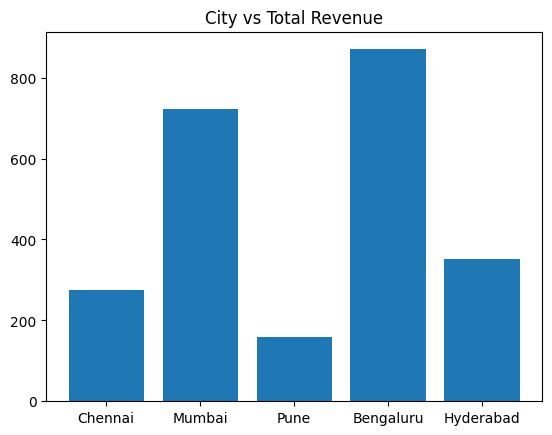

In [49]:
print("\n===  Visualization ===")
import matplotlib.pyplot as plt
city_revenue = gold_df.groupBy("city").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.bar(city_revenue["city"], city_revenue["total_revenue"])
plt.title("City vs Total Revenue")
plt.show()



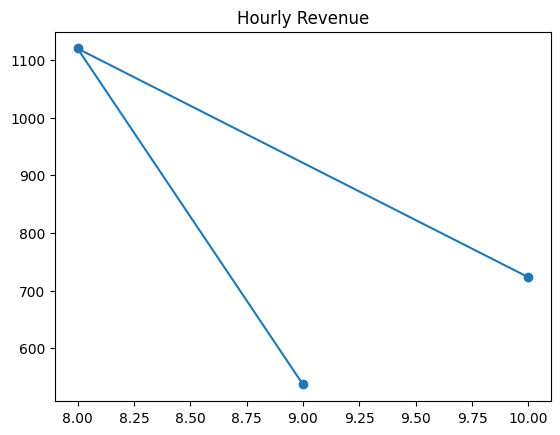

In [50]:
hourly_rev = gold_df.withColumn("hour", F.hour("ts")) \
                    .groupBy("hour").agg(F.sum("total_amount").alias("total_revenue")).toPandas()
plt.plot(hourly_rev["hour"], hourly_rev["total_revenue"], marker="o")
plt.title("Hourly Revenue")
plt.show()

#Managed vs Unmanaged Cleanup

In [51]:
print("\n=== Managed vs Unmanaged Cleanup ===")
spark.sql("DROP TABLE trips_managed")
spark.sql("DROP TABLE drivers_ext")
print("Managed table data removed; unmanaged data still present at:", DRIVERS_PATH)


=== Managed vs Unmanaged Cleanup ===
Managed table data removed; unmanaged data still present at: /tmp/delta/ride_hailing/drivers


#Constraint/Quality Check

In [52]:
print("\n===  Constraint/Quality Check ===")
bad_data = [(1011,"R010","D010","Chennai", 5.0, 200.0, -5.0, datetime.datetime(2025,8,8,11,0,0))]
df_bad = spark.createDataFrame(bad_data, trip_schema)
df_good = df_bad.filter(F.col("tip") >= 0)
df_good.show()


===  Constraint/Quality Check ===
+-------+--------+---------+----+-----------+----+---+---+
|trip_id|rider_id|driver_id|city|distance_km|fare|tip| ts|
+-------+--------+---------+----+-----------+----+---+---+
+-------+--------+---------+----+-----------+----+---+---+



#Convert Parquet → Delta

In [54]:
print("\n=== Convert Parquet → Delta ===")
PARQ_PATH = f"{BASE}/parquet_subset"
delta_trips.toDF().limit(2).write.mode("overwrite").parquet(PARQ_PATH)
spark.sql(f"CONVERT TO DELTA parquet.`{PARQ_PATH}`")
spark.read.format("delta").load(PARQ_PATH).show()


=== Convert Parquet → Delta ===
+-------+--------+---------+------+-----------+-----+----+-------------------+
|trip_id|rider_id|driver_id|  city|distance_km| fare| tip|                 ts|
+-------+--------+---------+------+-----------+-----+----+-------------------+
|   1008|    R007|     D013|Mumbai|        5.0|200.0|15.0|2025-08-08 10:00:00|
|   1009|    R008|     D012|Mumbai|        7.0|250.0|20.0|2025-08-08 10:05:00|
+-------+--------+---------+------+-----------+-----+----+-------------------+



#Bonus KPI Dashboard


===  Bonus KPI Dashboard ===
Total Revenue: 2380.0


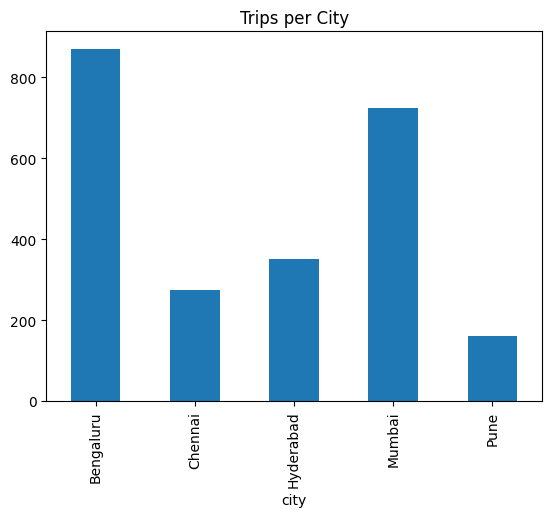

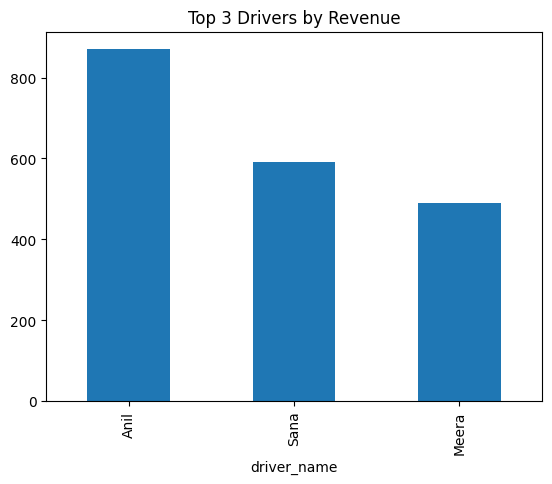

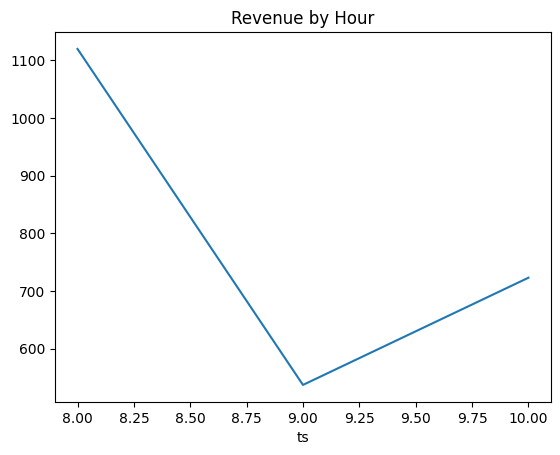

In [55]:
print("\n===  Bonus KPI Dashboard ===")
gold_pd = gold_df.toPandas()
print("Total Revenue:", gold_pd["total_amount"].sum())
gold_pd.groupby("city")["total_amount"].sum().plot(kind="bar", title="Trips per City")
plt.show()
gold_pd.groupby("driver_name")["total_amount"].sum().nlargest(3).plot(kind="bar", title="Top 3 Drivers by Revenue")
plt.show()
gold_pd.groupby(gold_pd["ts"].dt.hour)["total_amount"].sum().plot(kind="line", title="Revenue by Hour")
plt.show()